**Introduction**: In this EDA notebook our approach leverages the power of the CLIP (Contrastive Language–Image Pretraining) model to extract high-quality embeddings from images. These embeddings capture deep semantic relationships between images, providing a rich numerical representation of their content.We will store embeddings for real and fake images for further analysis.We will verify that the embeddings generated by CLIP are properly normalized.To measure similarity between images,we will compute the pairwise dot product between embeddings.



Mount the Google Drive in a Google Colab environment



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install torch==2.5.0 torchvision ftfy regex tqdm git+https://github.com/openai/CLIP.git

Load the dataset and generate image URLs


In [ ]:
'''import pandas as pd
import urllib.request
import time

df = pd.read_csv('drive/MyDrive/colab_notebooks/label_data.txt', sep='\t')
df['url'] = 'https://i.pinimg.com/736x/' + df['signature'].str[0:2] + '/' + df['signature'].str[2:4] + '/' + df['signature'].str[4:6] + '/' + df['signature'] +'.jpg'
df['image_name'] = df['signature']
del df['signature']
df.head()
df.to_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')'''

"import pandas as pd\nimport urllib.request\nimport time\n\ndf = pd.read_csv('drive/MyDrive/colab_notebooks/label_data.txt', sep='\t')\ndf['url'] = 'https://i.pinimg.com/736x/' + df['signature'].str[0:2] + '/' + df['signature'].str[2:4] + '/' + df['signature'].str[4:6] + '/' + df['signature'] +'.jpg'\ndf['image_name'] = df['signature']\ndel df['signature']\ndf.head()\ndf.to_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')"

In [ ]:
#After generating urls we save here in below folder. you need to run the above code block if you want to add more images to dataset.
'''import pandas as pd
import urllib.request
import time

df = pd.read_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')

for url in df['url'].to_list():
  file_name = url.split('/')[-1]
  time.sleep(1)
  try:
    urllib.request.urlretrieve(url, f'drive/MyDrive/colab_notebooks/images/{file_name}')
  except:
    print(url)'''

# Read images and generate CLIP embeddings

In below code we will set up the CLIP model from OpenAI and define a function to extract the embeddings from our images using the CLIP model.

In [3]:
%%capture
!pip install transformers

Using Hugging Face CLIP Model and testing it for a sample

In [4]:
#Using Hugging Face CLIP Model and testing it for a sample

import torch
from transformers import CLIPModel, CLIPProcessor
from PIL import Image

# Select device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Hugging Face CLIP model & processor
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)

def get_image_embeddings(image_path):
    # Open image
    image = Image.open(image_path).convert("RGB")

    # Preprocess via processor
    inputs = processor(images=image, return_tensors="pt").to(device)

    # HF style: get_image_features (not encode_image)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features

# Test
embeddings = get_image_embeddings("drive/MyDrive/colab_notebooks/images/0a207d43dfa8e56431151357da1ecae7.jpg")
print(embeddings.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

torch.Size([1, 512])


Find if the embeddings are normalized, if not apply normalization

In [5]:
from sklearn.preprocessing import normalize

# Check if embeddings are already normalized
# Calculate L2 norm of each embedding vector
norms = torch.linalg.norm(embeddings, dim=1)
print("Embedding Norms:", norms)

# If your embeddings are normalized, each value in 'norms' should be ~1.0
is_normalized = torch.allclose(norms, torch.ones_like(norms), atol=1e-3)
print("Embeddings are normalized?", is_normalized)

# Normalize embeddings if needed
if not is_normalized:
    embeddings = embeddings / norms.unsqueeze(1)
    norms_after = torch.linalg.norm(embeddings, dim=1)
    print("Norms after normalization:", norms_after)

Embedding Norms: tensor([10.8353])
Embeddings are normalized? False
Norms after normalization: tensor([1.])


Read the dataframe with label data

In [6]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')
print(df.head())

   Unnamed: 0               query  is_ai_generated  \
0           0  Golden_Gate_Bridge                0   
1           1                Mars                1   
2           2                Mars                1   
3           3                Mars                1   
4           4                Mars                1   

                                                 url  \
0  https://i.pinimg.com/736x/35/45/03/354503ce717...   
1  https://i.pinimg.com/736x/d5/98/17/d59817583d8...   
2  https://i.pinimg.com/736x/3d/1d/e4/3d1de42b3f4...   
3  https://i.pinimg.com/736x/00/be/ca/00becac4c25...   
4  https://i.pinimg.com/736x/0a/5b/ae/0a5bae79ca6...   

                         image_name  
0  354503ce71788b2f7725480f7a96123c  
1  d59817583d8f5081d293afe840ea3da4  
2  3d1de42b3f41903ee6f768eb26de95c7  
3  00becac4c25ad5a0c839e1629bedb899  
4  0a5bae79ca67e303fe64e0db70565ed1  


In [7]:
df.count()

,0
Unnamed: 0,3090
query,3090
is_ai_generated,3090
url,3090
image_name,3090


In [8]:
df.describe()

,Unnamed: 0,is_ai_generated
count,3090.000000,3090.000000
mean,1544.500000,0.434304
std,892.150492,0.495745
min,0.000000,0.000000
25%,772.250000,0.000000
50%,1544.500000,0.000000
75%,2316.750000,1.000000
max,3089.000000,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       3090 non-null   int64 
 1   query            3090 non-null   object
 2   is_ai_generated  3090 non-null   int64 
 3   url              3090 non-null   object
 4   image_name       3090 non-null   object
dtypes: int64(2), object(3)
memory usage: 120.8+ KB


In [54]:
df[df['is_ai_generated']==1].count()

,0
Unnamed: 0,1342
query,1342
is_ai_generated,1342
url,1342
image_name,1342


Real images count = 1748
AI generated images count = 1342

# Store all the embeddings

We dont have to run the below code block all the **time**

# Read the embeddings and labels in a csv file




In [55]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')
print(df.head())

def string_to_float_array(s):
    s = s.replace('[', '').replace(']', '')
    return np.array([float(x) for x in s.split(',')])

df_embeddings = pd.read_csv('drive/MyDrive/colab_notebooks/embeddings.csv')
df_embeddings.head()

   Unnamed: 0               query  is_ai_generated  \
0           0  Golden_Gate_Bridge                0   
1           1                Mars                1   
2           2                Mars                1   
3           3                Mars                1   
4           4                Mars                1   

                                                 url  \
0  https://i.pinimg.com/736x/35/45/03/354503ce717...   
1  https://i.pinimg.com/736x/d5/98/17/d59817583d8...   
2  https://i.pinimg.com/736x/3d/1d/e4/3d1de42b3f4...   
3  https://i.pinimg.com/736x/00/be/ca/00becac4c25...   
4  https://i.pinimg.com/736x/0a/5b/ae/0a5bae79ca6...   

                         image_name  
0  354503ce71788b2f7725480f7a96123c  
1  d59817583d8f5081d293afe840ea3da4  
2  3d1de42b3f41903ee6f768eb26de95c7  
3  00becac4c25ad5a0c839e1629bedb899  
4  0a5bae79ca67e303fe64e0db70565ed1  


,embeddings,image_name,label
0,"[[0.12522172927856445, 0.17127607762813568, -0...",354503ce71788b2f7725480f7a96123c,0
1,"[[0.00956397969275713, -0.024535341188311577, ...",d59817583d8f5081d293afe840ea3da4,1
2,"[[-0.014325050637125969, 0.026381907984614372,...",3d1de42b3f41903ee6f768eb26de95c7,1
3,"[[-0.09597162157297134, 0.10650302469730377, -...",00becac4c25ad5a0c839e1629bedb899,1
4,"[[0.368219792842865, 0.17371228337287903, -0.0...",0a5bae79ca67e303fe64e0db70565ed1,1


#Normalize the embeddings in df

In [56]:
from sklearn.preprocessing import normalize

#Lets normalize all the embeddings in our df_embeddings

import ast
import torch
import pandas as pd
from sklearn.preprocessing import normalize


def normalize_embeddings_in_df(df_embeddings, embedding_col: str = "embeddings", atol=1e-3):

    for i in range(len(df_embeddings)):
        #  Retrieve the embedding from the DataFrame
        e = df_embeddings.at[i, embedding_col]

        # If it's a string, parse it into a Python list
        if isinstance(e, str):
            e = ast.literal_eval(e)  # Convert "[0.12, 0.34, ...]" -> [0.12, 0.34, ...]

        # Convert to a PyTorch tensor
        embedding_tensor = torch.tensor(e, dtype=torch.float32)

        # Calculate the L2 norm
        norm = torch.linalg.norm(embedding_tensor)

        # Check if it's (approximately) 1
        is_normalized = torch.allclose(norm, torch.ones(1), atol=atol)

        if not is_normalized:
        # Normalize the tensor
            embedding_tensor = embedding_tensor / norm

        # Store back into the DataFrame as a Python list
        df_embeddings.at[i, embedding_col] = embedding_tensor.tolist()


df_embeddings.head()

,embeddings,image_name,label
0,"[[0.12522172927856445, 0.17127607762813568, -0...",354503ce71788b2f7725480f7a96123c,0
1,"[[0.00956397969275713, -0.024535341188311577, ...",d59817583d8f5081d293afe840ea3da4,1
2,"[[-0.014325050637125969, 0.026381907984614372,...",3d1de42b3f41903ee6f768eb26de95c7,1
3,"[[-0.09597162157297134, 0.10650302469730377, -...",00becac4c25ad5a0c839e1629bedb899,1
4,"[[0.368219792842865, 0.17371228337287903, -0.0...",0a5bae79ca67e303fe64e0db70565ed1,1


#Generate a heatmap for random images from the image pool which would display the pairwise dot product similarities.

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

def create_image_embedding_heatmap(df_embeddings,
                                   embedding_col="embeddings",
                                   num_images=50,
                                   random_state=None):

    # sample rows - this is to make sure we put a nember which is lower than our lenth of emeddings rows.
    if num_images > len(df_embeddings):
        raise ValueError(
            f"Requested num_images={num_images} > DataFrame length={len(df_embeddings)}."
        )
    #picks the random images from our df_embeddings
    df_sampled = df_embeddings.sample(n=num_images, random_state=random_state)

    # parse each embedding, fix shape, stack
    parsed_embeddings = []
    for i, row in df_sampled.iterrows():
        emb = row[embedding_col] #emb is the embedding from each row

    # If emb is still a string, parse it if required
    # If it's already a list, skip
        if isinstance(emb, str): #if its a string convert to list.
            import ast
            emb = ast.literal_eval(emb)

    # Convert to NumPy array
        arr = np.array(emb, dtype=float)

    # If you have shape [1, d], squeeze to [d]
        if arr.ndim == 2 and arr.shape[0] == 1:
            arr = arr.squeeze(axis=0)

    # Now arr should be shape [d]
        parsed_embeddings.append(arr)

    # Convert the list of arrays into a 2D NumPy array [num_images, embedding_dim]
    embeddings_np = np.vstack(parsed_embeddings)

    embeddings_np = normalize(embeddings_np, norm="l2")  # Now each vector has norm = 1
    # compute dot-product similarity matrix [num_images, num_images]
    dot_product_matrix = embeddings_np @ embeddings_np.T

    # plot heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(dot_product_matrix, cmap="coolwarm", annot=False)
    plt.title("Pairwise Dot Product Heatmap")
    plt.xlabel("Embeddings")
    plt.ylabel("Embeddings")
    plt.show()

# Check if embedding are normaized.

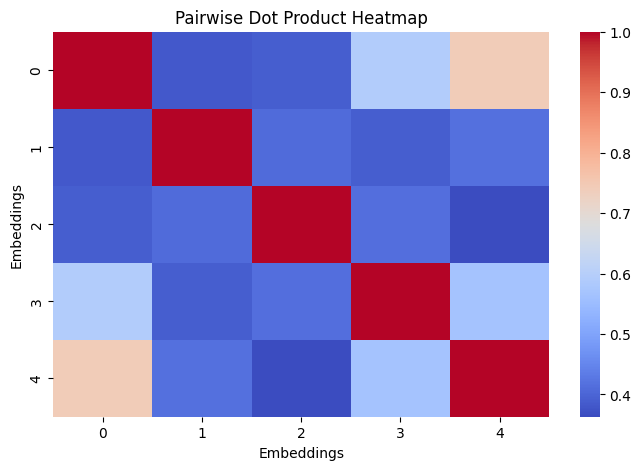

In [59]:
create_image_embedding_heatmap(df_embeddings, embedding_col="embeddings",
    num_images=5,
    random_state=42)

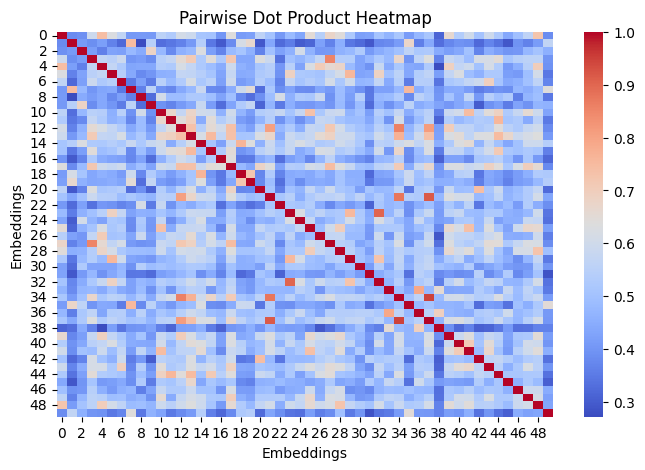

In [60]:
create_image_embedding_heatmap(
    df_embeddings,
    embedding_col="embeddings",
    num_images=50,
    random_state=42
)

Summary from above Heatmap
1. The diagonal line red represents becasue the image is most similar to itself.
2. Because these are random images we dont see any strong similarity within the images.
3. The higher the number more similarity.


In [48]:
%%capture
!pip install plotly dash

# Use PCA to reduce dimensions and visualize.

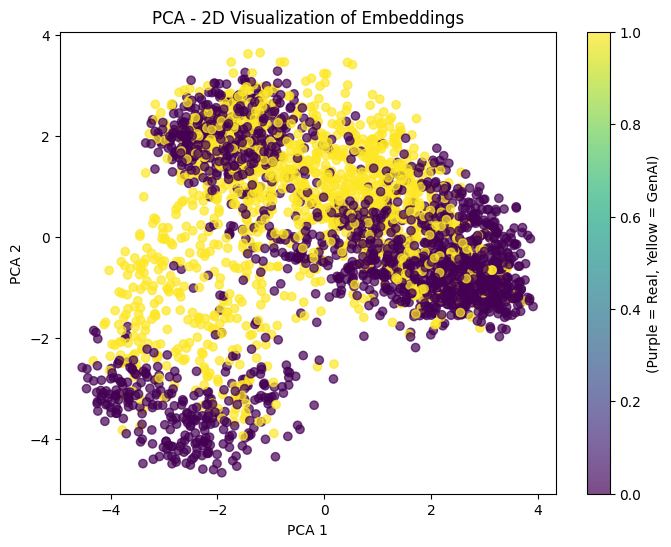

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert embeddings to a numpy array
#embeddings = np.array(df['parsed_embeddings'].to_list())

# Convert embeddings to a 2D NumPy array
import ast

# Convert string embeddings to list if needed
df_embeddings['embeddings'] = df_embeddings['embeddings'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all embeddings are the same length
embedding_dim = len(df_embeddings['embeddings'].iloc[0])  # Assume first row is correct
df = df_embeddings[df_embeddings['embeddings'].apply(lambda x: len(x) == embedding_dim)]  # Filter mismatched sizes

# Convert to NumPy array
embeddings = np.vstack(df_embeddings['embeddings'].to_list())

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Add PCA results to dataframe
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Plot in 2D
plt.figure(figsize=(8, 6))
plt.scatter(df['pca_1'], df['pca_2'], c=df['label'], cmap='viridis', alpha=0.7)
plt.colorbar(label='(Purple = Real, Yellow = GenAI)')
plt.title('PCA - 2D Visualization of Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


Summary from above chart
1. The embeddings from CLIP seem to have enough variance to form meaningful clusters.
2. If PCA 1 and PCA 2 had captured too little variance, the points would be tightly packed without clear clusters.
3. The fact that the clusters are spread out means that the embeddings have meaningful and discriminative features.
4. The clustering suggests that CLIP embeddings capture patterns that differentiate real and AI-generated images.
5. Overlapping areas suggest that some AI-generated images are highly realistic, making it difficult for the model to distinguish them.
6. The separation confirms that a classification model should be able to achieve high accuracy based on these embeddings.

In [92]:
%%capture
!pip install pillow

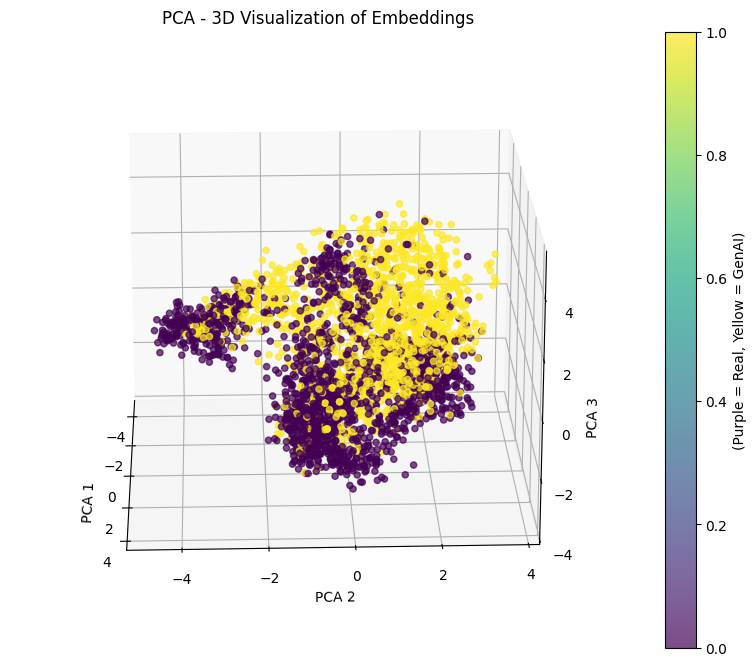

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation


# Apply PCA for 3D visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(embeddings)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                c=df['label'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='(Purple = Real, Yellow = GenAI)')
ax.set_title('PCA - 3D Visualization of Embeddings')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

#Define a function to update the view angle
def update(frame):
    ax.view_init(elev=20, azim=frame)  # Rotate angle (azim) per frame
    return fig,

#Create animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)


#Save the animation as a GIF
ani.save('3D_scatter_rotation.gif', writer='pillow', fps=20)

plt.show()


Summary from above chart
1. There are distinct clusters forming, suggesting that the embeddings contain meaningful patterns that allow for separation.
2. Some degree of overlap → Certain AI-generated images closely resemble real ones.
3. The separation is clearer in 3D compared to the 2D plot, suggesting that the third component adds useful variance for discrimination.
4. The points are spread across all three PCA components → suggesting that the variance is not confined to just two dimensions.
5. The spread along PCA 3 means that the third component is capturing valuable discriminative patterns.
6. If the points were tightly clustered, the model would struggle to distinguish between real and AI-generated images.
7. The wide spread across PCA 1, PCA 2, and PCA 3 indicates that CLIP embeddings hold enough variance to support a classification model.
8. The embeddings form clearer clusters → Suggests that a classification model should be able to effectively learn the patterns.
9. Overlapping areas reflect that some AI-generated images are highly realistic.
10. A more complex model (like a vision transformer) might be needed to improve separation.
11. The separation suggests that clustering techniques (like KMeans or DBSCAN) could identify patterns without labels.
12. Cosine similarity on embeddings can be used to measure how close AI-generated images are to real ones.



#2D and 3D t-SNE for Visualization

t-SNE is more effective for capturing complex relationships and local structures in high-dimensional data

2D t-SNE visualization

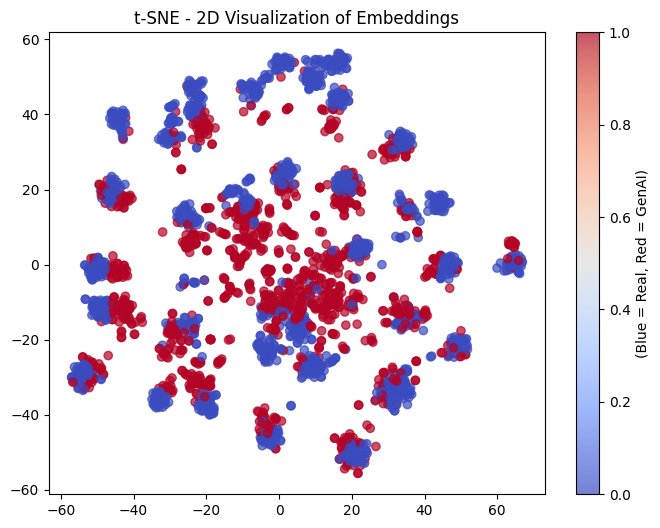

In [64]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Add t-SNE results to dataframe
df['tsne_1'] = tsne_result[:, 0]
df['tsne_2'] = tsne_result[:, 1]

# Plot in 2D
plt.figure(figsize=(8, 6))
plt.scatter(df['tsne_1'], df['tsne_2'], c=df['label'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='(Blue = Real, Red = GenAI)')
plt.title('t-SNE - 2D Visualization of Embeddings')
#plt.xlabel('t-SNE 1')
#plt.ylabel('t-SNE 2')
plt.show()

Summary from above graph
1. The clusters indicate that the embeddings contain some identifiable differences between real and AI-generated images.
2. Clusters at the edges of the plot suggest that certain real or GenAI images are more distinctly different.
3. Overlapping areas (blue and red dots mixed) suggest that some AI-generated images resemble real ones.
4. This shows that certain AI-generated images might be harder to distinguish from real ones.
5. Good separation of clusters Embeddings are informative for classification.
6. High overlap More complex patterns requiring deeper feature extraction or more sophisticated models.


t-SNE for 3D visualization

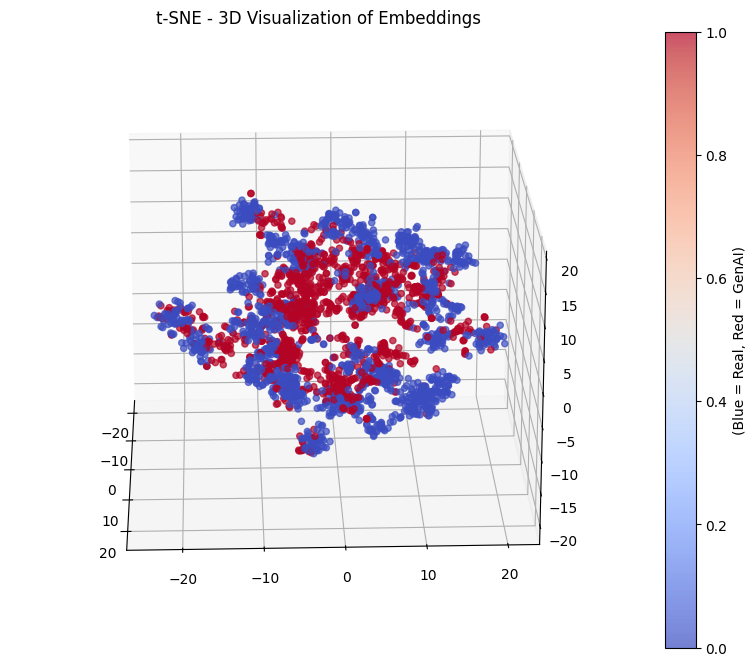

In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2],
                c=df['label'], cmap='coolwarm', alpha=0.7)
plt.colorbar(sc, label='(Blue = Real, Red = GenAI)')
ax.set_title('t-SNE - 3D Visualization of Embeddings')
#ax.set_xlabel('t-SNE 1')
#ax.set_ylabel('t-SNE 2')
#ax.set_zlabel('t-SNE 3')

# function to update the view angle for animation
def update(frame):
    ax.view_init(elev=20, azim=frame)  # Rotate azimuth per frame
    return fig,
#Create animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)

#Save the animation as a GIF
ani.save('tSNE_3D_scatter_rotation.gif', writer='pillow', fps=20)


plt.show()

Summary from the above graph
1. We can observe less overlapping, good seperated and distinct clusters. This suggests that Classification Models would work for training.

Summary for PCA and t-SNE
t-SNE is better at clustering high-dimensional data because it focuses on preserving local similarities.
Since embeddings from CLIP encode subtle differences in patterns (like textures, edges, and details), t-SNE helps reveal these fine-grain patterns more effectively than PCA.

